In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

RSEED = 42
dataset_path = '../data/filtered_testset/train_all'

In [2]:
def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [3]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 69138 files belonging to 25 classes.
Using 55311 files for training.
Using 13827 files for validation.


2024-02-22 23:22:56.572940: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-22 23:22:56.572973: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-22 23:22:56.572983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-22 23:22:56.573347: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-22 23:22:56.573715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
import tensorflow.keras.backend as K
K.clear_session()

In [5]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [6]:
from keras import layers
IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [7]:
model = build_model(num_classes=25)

In [8]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


In [9]:
# Create a new model with unfrozen layers
model_filtered = unfreeze_model_and_clone(model)

epochs = 10
history2 = model_filtered .fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10


2024-02-22 23:29:49.626498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1729/1729 [==============================] - 512s 294ms/step - loss: 1.8505 - accuracy: 0.5203 - val_loss: 0.8618 - val_accuracy: 0.7744
Epoch 2/10
1729/1729 [==============================] - 510s 294ms/step - loss: 0.8324 - accuracy: 0.7673 - val_loss: 0.5374 - val_accuracy: 0.8483
Epoch 3/10
1729/1729 [==============================] - 512s 296ms/step - loss: 0.5998 - accuracy: 0.8249 - val_loss: 0.4141 - val_accuracy: 0.8783
Epoch 4/10
1729/1729 [==============================] - 511s 295ms/step - loss: 0.4792 - accuracy: 0.8553 - val_loss: 0.3479 - val_accuracy: 0.8934
Epoch 5/10
1729/1729 [==============================] - 512s 296ms/step - loss: 0.4115 - accuracy: 0.8736 - val_loss: 0.3062 - val_accuracy: 0.9046
Epoch 6/10
1729/1729 [==============================] - 507s 293ms/step - loss: 0.3640 - accuracy: 0.8872 - val_loss: 0.2758 - val_accuracy: 0.9144
Epoch 7/10
1729/1729 [==============================] - 500s 289ms/step - loss: 0.3289 - accuracy: 0.8975 - val_loss: 0.255

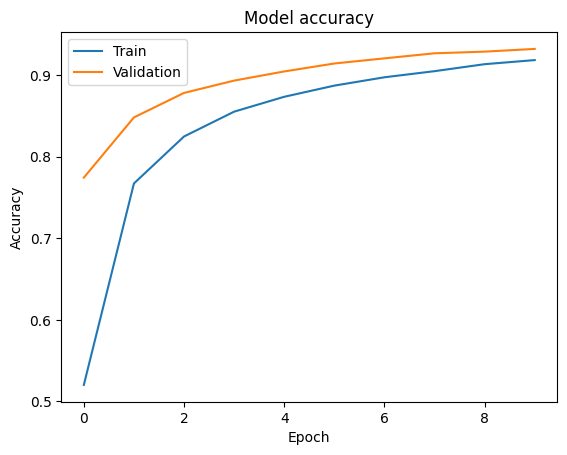

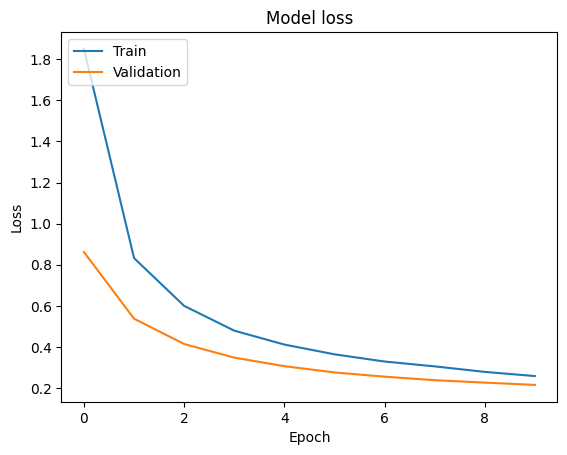

In [10]:
# Plot training & validation accuracy values
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

test_dataset_path = '../data/filtered_testset/test_all'

In [12]:
test_ds = load_test(test_dataset_path)

Found 17285 files belonging to 25 classes.


In [13]:
# Make predictions on the test dataset
predictions = model_filtered .predict(test_ds)

541/541 [==============================] - 119s 214ms/step


In [14]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = model_filtered .predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

541/541 [==============================] - 112s 207ms/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.89      0.89      0.89        56
    bacterial_blight       0.83      0.74      0.78       573
      bacterial_spot       0.96      0.96      0.96      1067
      bacterial_wilt       0.95      0.87      0.91       118
       black_measles       0.96      0.97      0.96       492
           black_rot       0.96      0.95      0.96       376
               blast       0.99      0.96      0.98       291
          brown_spot       0.94      0.93      0.93       735
brown_streak_disease       0.66      0.56      0.61       455
     citrus_greening       1.00      1.00      1.00      1157
         common_rust       1.00      0.99      1.00       246
        early_blight       0.93      0.88      0.90       696
      gray_leaf_spot       0.88      0.88      0.88        93
             healthy       0.93      0.93      0.

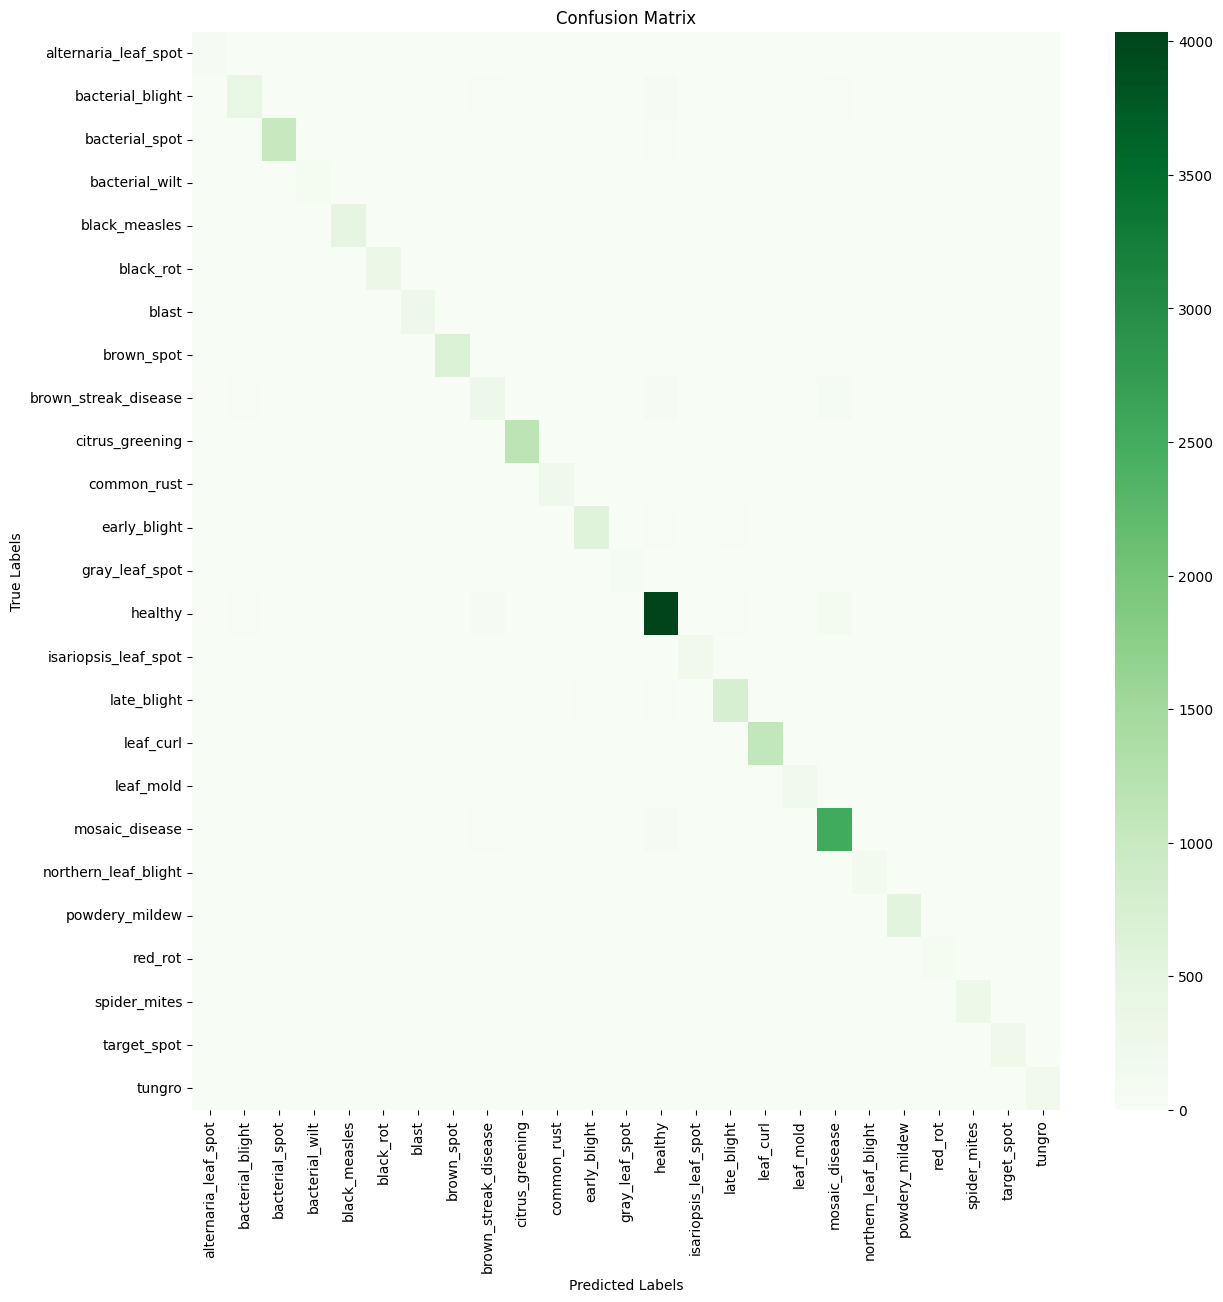

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# save model

# Save the trained model to the specified directory
model_dir = "../models/"
model_filename = "model_filtered.h5"
model_filtered.save(os.path.join(model_dir, model_filename))

/Users/olugbengaoloyade/Documents/capstone_project/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# -----------------------------------------------

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

test_dataset2_path = '../data/external_test_data'

In [26]:
test_ds2 = load_test(test_dataset2_path)

Found 55 files belonging to 25 classes.


In [27]:
# Make predictions on the test dataset
predictions2 = model_filtered .predict(test_ds2)

2024-02-23 10:29:11.946974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 3s 2s/step


In [28]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds2.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred2_probabilities = model_filtered .predict(test_ds2)

# Step 4: Convert the predicted class probabilities to class labels
y_pred2_indices = np.argmax(y_pred2_probabilities, axis=1)
y_pred2 = [classes[i] for i in y_pred2_indices]

# Step 5: Generate the classification report
report2 = classification_report(y_true, y_pred2)
print("Classification Report:")
print(report2)


2024-02-23 10:29:18.796306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2/2 [==============================] - 1s 707ms/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.00      0.00      0.00         2
    bacterial_blight       0.00      0.00      0.00         3
      bacterial_spot       0.00      0.00      0.00         3
      bacterial_wilt       1.00      0.50      0.67         2
       black_measles       0.33      0.50      0.40         2
           black_rot       0.29      1.00      0.44         2
               blast       1.00      0.50      0.67         2
          brown_spot       0.25      1.00      0.40         1
brown_streak_disease       0.00      0.00      0.00         2
     citrus_greening       0.00      0.00      0.00         2
         common_rust       1.00      1.00      1.00         2
        early_blight       0.00      0.00      0.00         2
      gray_leaf_spot       0.67      1.00      0.80         2
             healthy       0.62      0.71      0.67    

/Users/olugbengaoloyade/Documents/capstone_project/AgronomiCare/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/olugbengaoloyade/Documents/capstone_project/AgronomiCare/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/olugbengaoloyade/Documents/capstone_project/AgronomiCare/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

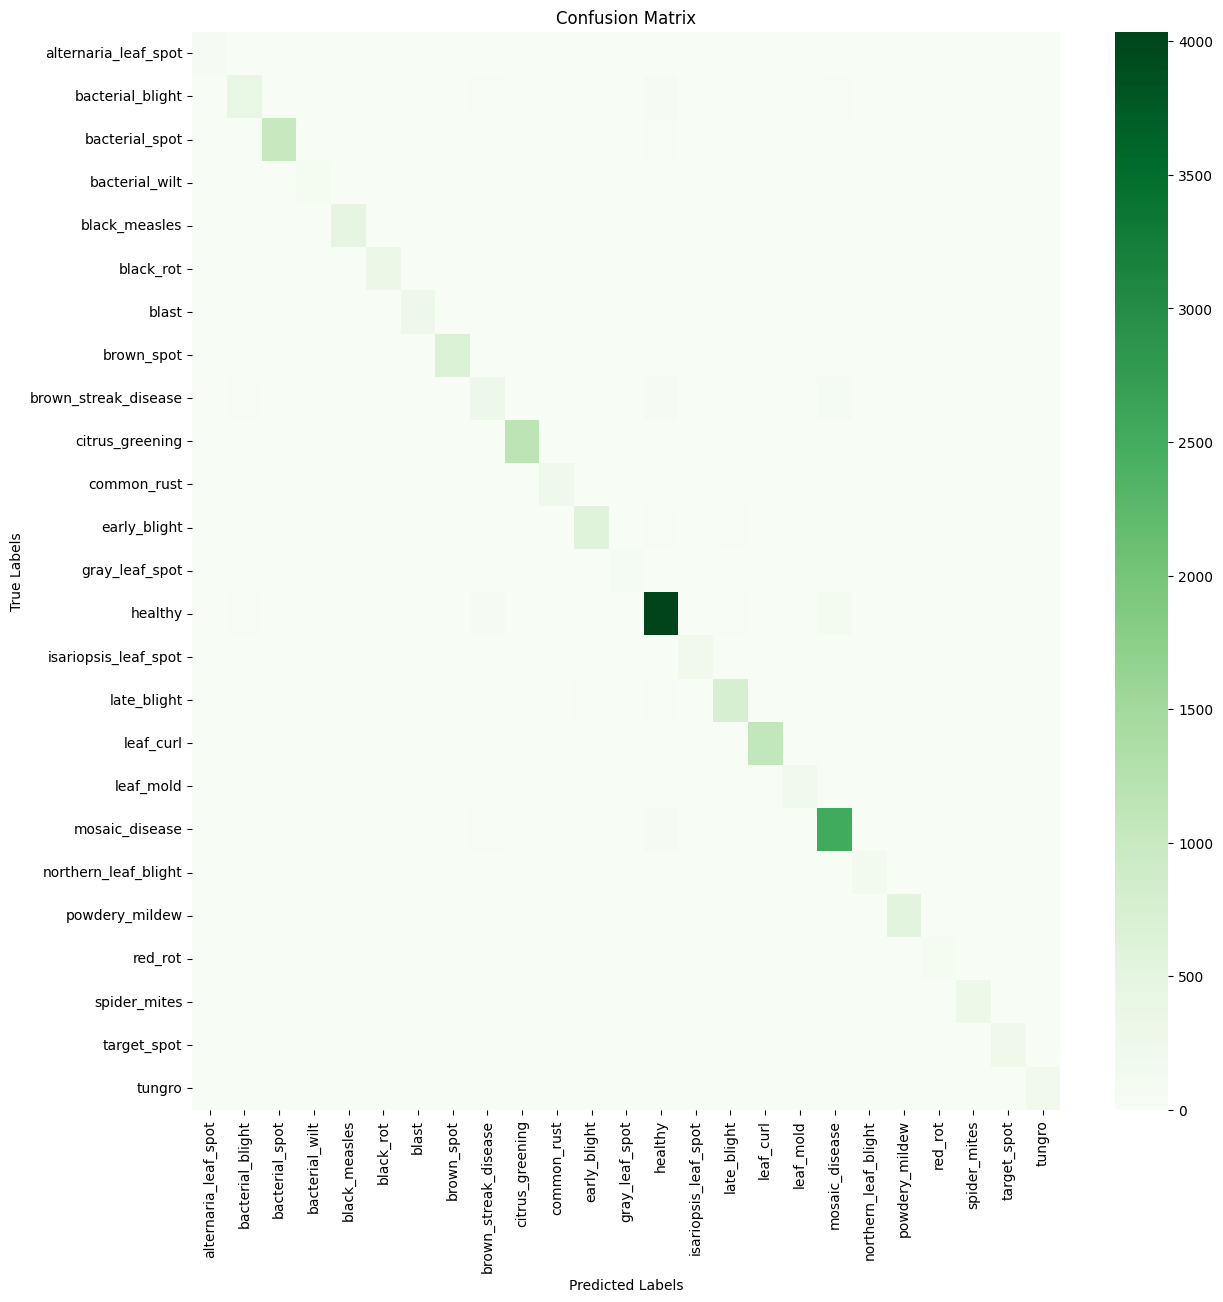

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

cm2 = confusion_matrix(y_true, y_pred2)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()